In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np
import time
import c3aidatalake

### Extraction of Counties

In [3]:
county_location_ids = pd.read_csv("C3-ai-Location-IDs.csv")
county_location_ids.info()
county_location_ids = county_location_ids[county_location_ids['County id'].str.contains('UnitedStates')]
county_location_ids = list(county_location_ids['County id'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   County id                                   3693 non-null   object
 1   County                                      3693 non-null   object
 2   State                                       3693 non-null   object
 3   Country                                     3693 non-null   object
 4   JHU                                         3249 non-null   object
 5   NYT: Case Counts                            2972 non-null   object
 6   University of Washington                    3 non-null      object
 7   US Census Bureau: Demographic Estimates     3219 non-null   object
 8   Corona Data Scraper                         3283 non-null   object
 9   Google                                      3049 non-null   object
 10  Apple                   

# Training Mobility Data

### This is the API call to the 6 types of mobility data. We do it in groups of 10 to prevent timeout 

In [12]:
today = pd.Timestamp.now().strftime("%Y-%m-%d")
county = []
start = time.time()


metrics = [
    "Google_ParksMobility",
    "Google_ResidentialMobility",
    "Google_GroceryMobility",
    "Google_TransitStationsMobility",
    "Google_RetailMobility",
    "Google_WorkplacesMobility"
]


for i in range(0, len(county_location_ids), 10):

    mobility_trends = c3aidatalake.evalmetrics(
        "outbreaklocation",
        {
            "spec" : {
                "ids" : county_location_ids[i:i+10],
                "expressions" : metrics,
                "start" : "2020-02-28",
                "end" : "2020-04-30",
                "interval" : "DAY",
            }
        },
        get_all = True
    )
    county.append(mobility_trends)

end = time.time()
print(f"Fetching data took {(end - start) / 60} minutes")

Fetching data took 46.83758586645126 minutes


Since all the data was stored as an array of many dataframes, we concatenate them all together 

In [30]:
df = pd.concat(county, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 0
Columns: 40475 entries, dates to Shannon_SouthDakota_UnitedStates.Google_RetailMobility.missing
dtypes: datetime64[ns](335), object(40140)
memory usage: 19.1+ MB


This column was used to put the day to help keep track of the daily mobility.

In [32]:
df.insert(0, "Day", list(range(0,62)), True)
df.to_csv('training_county_mobility_time_series_data.csv')

# Testing Mobility Data

### This is the API call to the 6 types of mobility data. We do it in groups of 10 to prevent timeout 

In [36]:
today = pd.Timestamp.now().strftime("%Y-%m-%d")
county = []
start = time.time()


metrics = [
    "Google_ParksMobility",
    "Google_ResidentialMobility",
    "Google_GroceryMobility",
    "Google_TransitStationsMobility",
    "Google_RetailMobility",
    "Google_WorkplacesMobility"
]


for i in range(0, len(county_location_ids), 10):

    mobility_trends = c3aidatalake.evalmetrics(
        "outbreaklocation",
        {
            "spec" : {
                "ids" : county_location_ids[i:i+10],
                "expressions" : metrics,
                "start" : "2020-04-30",
                "end" : "2020-05-30",
                "interval" : "DAY",
            }
        },
        get_all = True
    )
    county.append(mobility_trends)

end = time.time()
print(f"Fetching data took {(end - start) / 60} minutes")

Fetching data took 46.06452813943227 minutes


Since all the data was stored as an array of many dataframes, we concatenate them all together 

In [38]:
df = pd.concat(county, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 0
Columns: 40475 entries, dates to Shannon_SouthDakota_UnitedStates.Google_RetailMobility.missing
dtypes: datetime64[ns](335), object(40140)
memory usage: 9.3+ MB


This column was used to put the day to help keep track of the daily mobility.

In [41]:
df.insert(0, "Day", list(range(0,30)), True)
df.to_csv('testing_county_mobility_time_series_data.csv')

# Graphs

These graphs are generated for the PowerPoint and the Midterm Report

In [82]:
complete_timeseries = pd.read_csv("testing_county_mobility_time_series_data.csv")

In [83]:
# Population: https://www.georgia-demographics.com/counties_by_population
# Polk = 42,613  (MEH POPULOUS)
# Fulton =  1,063,937 (VERY POPULOUS)


# COVID RESTRICTIONS
# https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html
# Cass , North Dakota -- didn't have
# Queens, New York -- did have


temp =  ["Polk_Georgia_UnitedStates", "Fulton_Georgia_UnitedStates","Cass_NorthDakota_UnitedStates","Queens_NewYork_UnitedStates"]

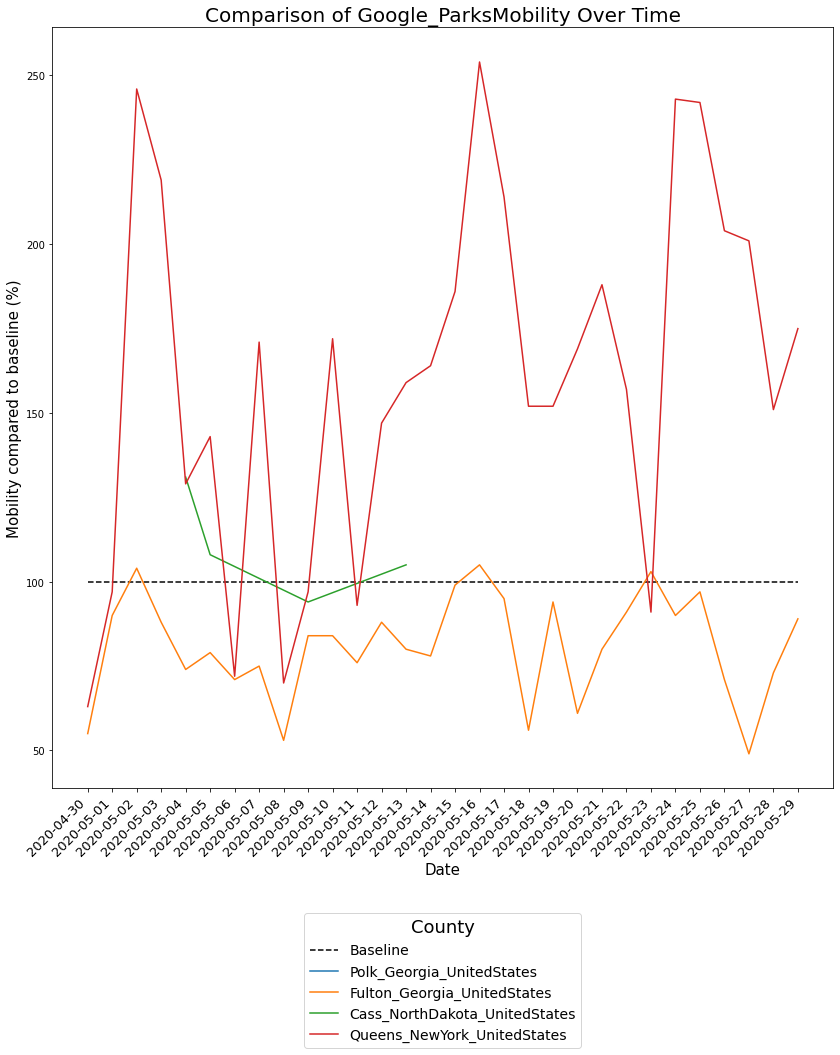

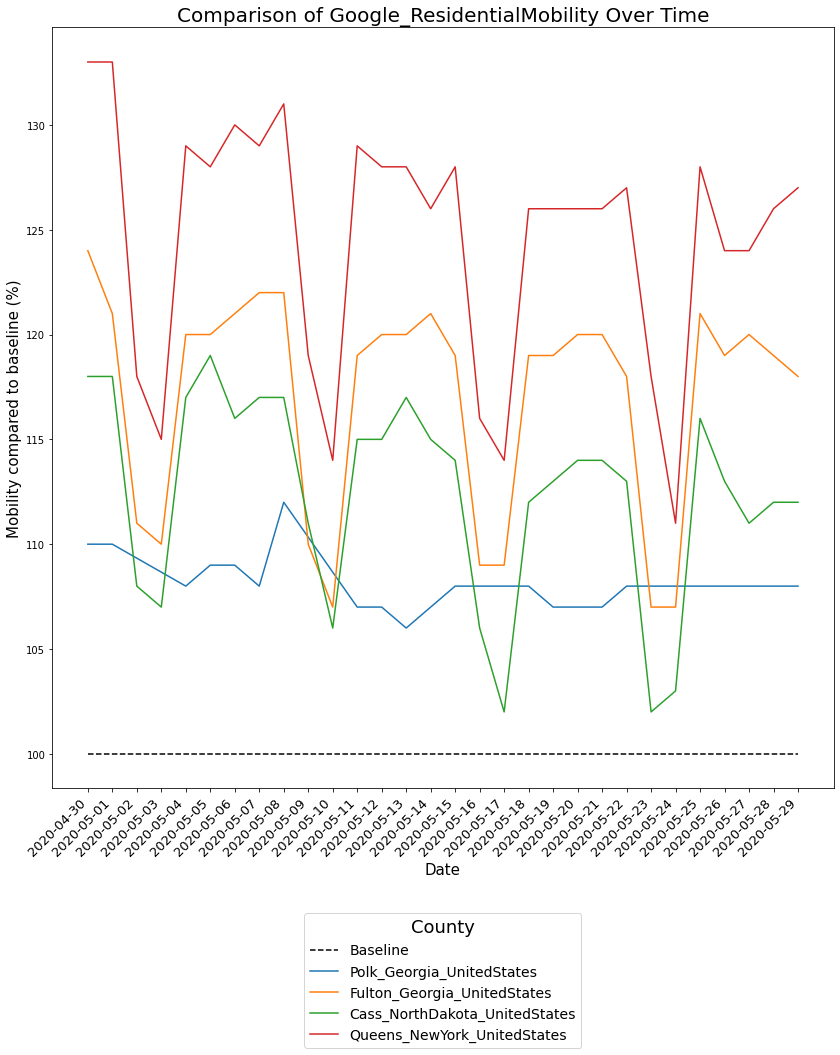

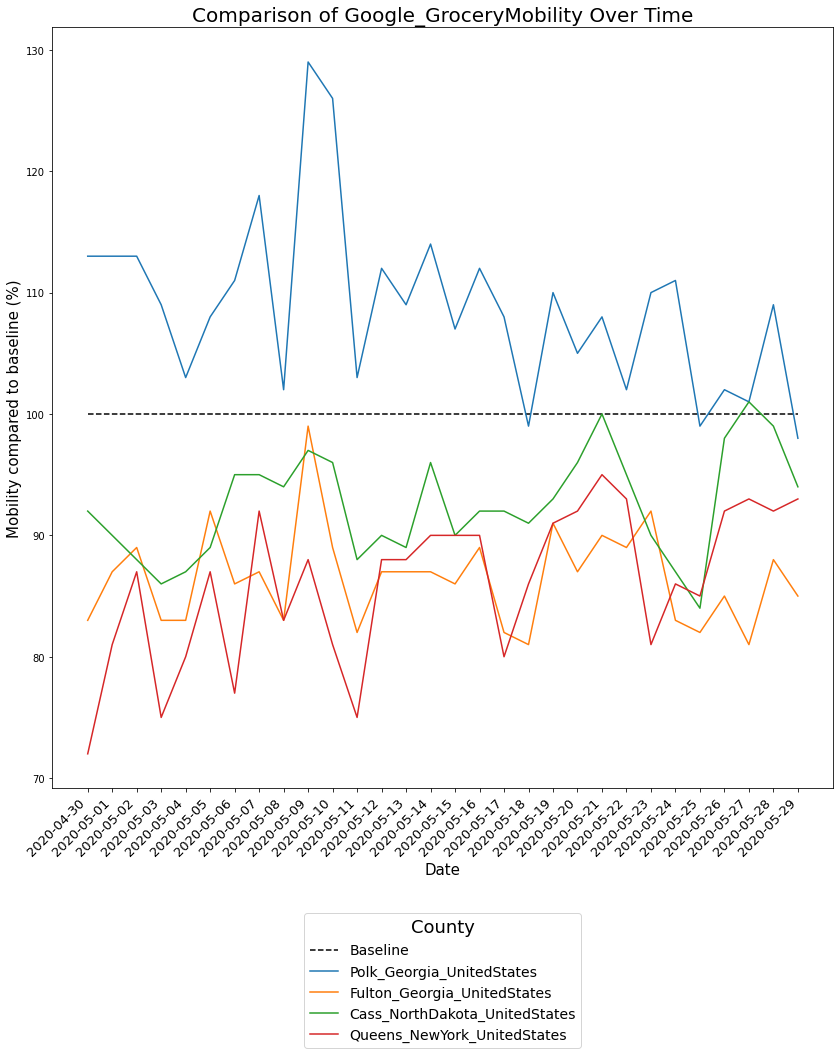

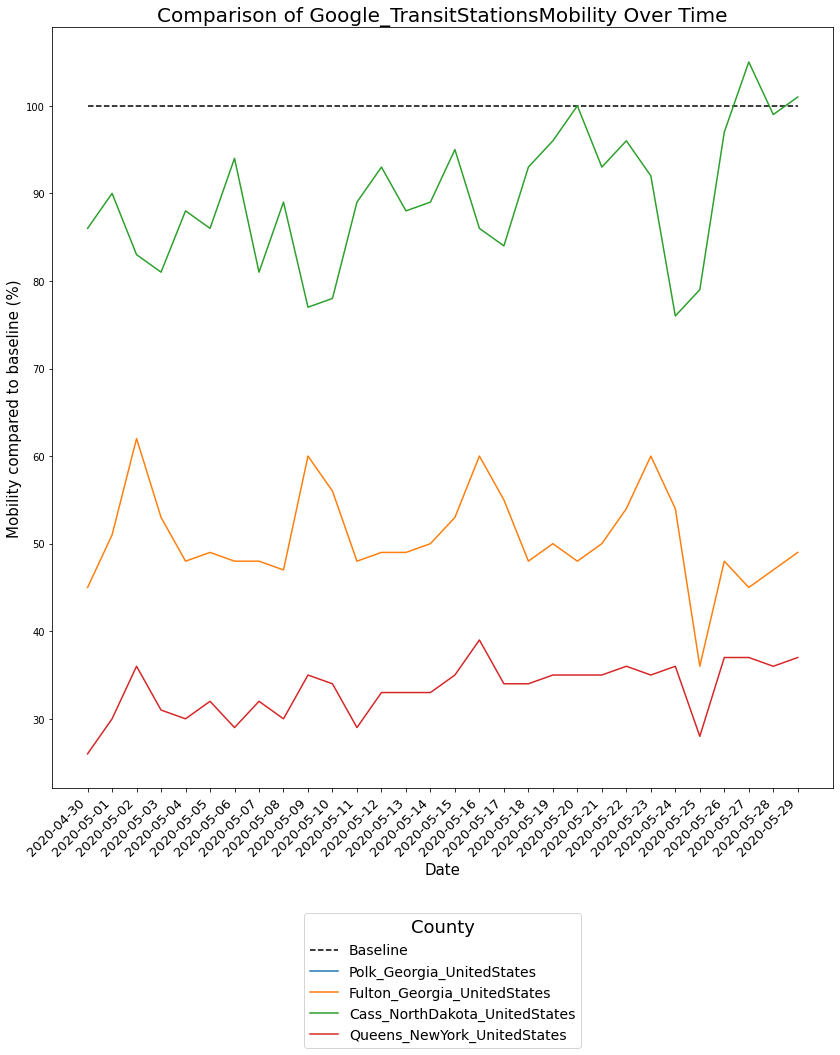

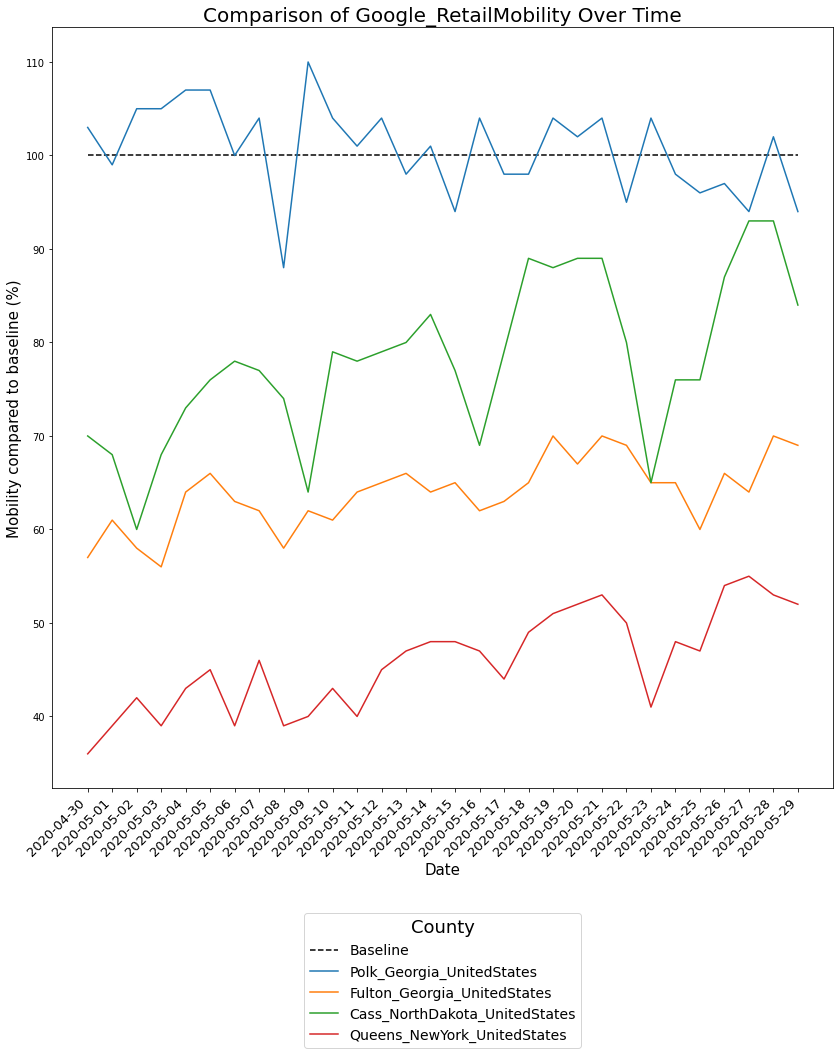

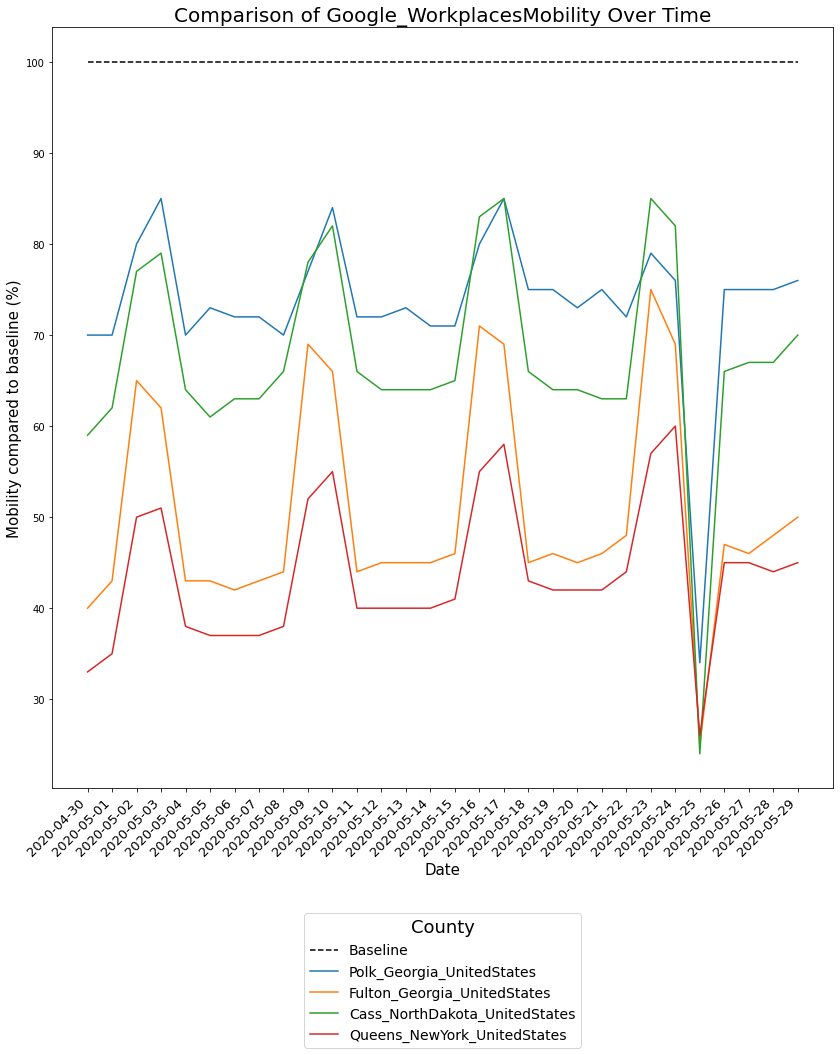

In [133]:
for metric in metrics:
    plt.figure(figsize = (14, 14))

    if "Mobility" in metric:
        plt.plot(
            complete_timeseries["dates"],
            [100 for d in complete_timeseries["dates"]],
            label = "Baseline",
            linestyle = "dashed",
            color = "black"
        )

    for location in temp:
        data_col = location + "." + metric + ".data"
        missing_col = location + "." + metric + ".missing"

        missing = list(complete_timeseries[missing_col])
        data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
        dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

        plt.plot(
            dates,
            data,
            label = location
        )

    plt.legend( loc='lower center', bbox_to_anchor=(.5, -.35), fontsize = 14, title = "County", title_fontsize = 18)
    plt.xticks(rotation = 45, ha = "right", fontsize = 13)
    plt.xlabel("Date", fontsize = 15)
    if "Mobility" in metric:
        plt.ylabel("Mobility compared to baseline (%)",  fontsize = 15)
    else:
        plt.ylabel("Count", fontsize = 13)
    plt.title("Comparison of " + metric + " Over Time", fontsize = 20)
    plt.show()
    print()
    print()
    print()
    print()
    print()

# Rolling Average Mobility Data Train

Since there was missing data for the mobility data, I used the rolling average to help fill in the holes! However, places where all the data was missing, I could not do anything.

Thus, in order to skip those columns, I changed all zeros to nulls. Then, I could check if a whole column had all nulls.

In [ ]:
mob = pd.read_csv("training_county_mobility_time_series_data.csv")
mob.replace(0, np.nan, inplace=True)
mob["Day"][0] = 0

In [ ]:
for (columnName, columnData) in mob.iteritems():
    if ".data" in columnName:
        if mob[columnName].isnull().all():
            pass
        else:
            mob[columnName] = (mob[columnName].interpolate())  

I replace back the nulls with 0s!

In [ ]:
mob.replace(np.nan, 0, inplace=True)
mob.to_csv('mobility_trial_testing.csv')

# Rolling Average Mobility Data Test

Since there was missing data for the mobility data, I used the rolling average to help fill in the holes! However, places where all the data was missing, I could not do anything.

Thus, in order to skip those columns, I changed all zeros to nulls. Then, I could check if a whole column had all nulls.

In [ ]:
mob2 = pd.read_csv("testing_county_mobility_time_series_data.csv")
mob2.replace(0, np.nan, inplace=True)
mob2["Day"][0] = 0

In [ ]:
for (columnName, columnData) in mob2.iteritems():
    if ".data" in columnName:
        if mob2[columnName].isnull().all():
            pass
        else:
            mob2[columnName] = (mob2[columnName].interpolate())  

I replace back the nulls with 0s!

In [ ]:
mob2.replace(np.nan, 0, inplace=True)
mob2.to_csv('mobility_testing_rolling.csv')

# Demographics Data

### Note: We did ditch this method since it would take 55 hours to run

### Since we did not use this code after all -- I will give a short summary of what it could do. Each subsection is an API call to get that demographic demographic data. For example, the Age subsection would be grabbing the age groups demographics. Then, all of these functions would be called per county and put into a csv. However, in 30 minutes, only 9 counties would be completed. We had over 3,000 counties to do this for, and limited time. Thus, we went a different route!

# Getting Total Population

In [4]:
def get_total_people(county):
    total = c3aidatalake.fetch(
    "populationdata",
    {
        "spec" : {
            "filter" : "contains(parent, " + county + ") &&(populationAge == 'Total') &&  year == 2018 && race == 'Any race'  && median == 'False' && percent == 'False'"
        }
    },
    get_all = True
    )
    total_people = np.sum(total.value.tolist())
    return total, total_people

# Age

In [5]:
def get_ages(county, total_people):
    older_65 = c3aidatalake.fetch(
    "populationdata",
    {
        "spec" : {
            "filter" : "contains(parent, " + county + ") &&(populationAge == '>=65') &&  year == 2018 && median == 'False'   && median == 'False'  && percent == 'False'  && gender == 'Male/Female'"
        }
    },
    get_all = True
    )
    
    older_65_total = np.sum(older_65.value.tolist())
    younger_65_total = total_people - older_65_total
    
    return [older_65_total,younger_65_total]

In [219]:
total, total_people = get_total_people(county)
get_ages(county, total_people)

[8653.0, 46880.0]

# Gender

In [6]:
def get_genders(total):
    female = np.sum(total.loc[total['gender'] == "Female"].value.tolist())
    male = np.sum(total.loc[total['gender'] == "Male"].value.tolist())
    
    return [male, female]

In [160]:
get_genders(total)

(27006.0, 28527.0)

# Ethnicity

In [7]:
def get_ethnicity(total):
    hispanic = np.sum(total.loc[total['ethnicity'] == "Hispanic"].value.tolist())
    not_hispanic = np.sum(total.loc[total['ethnicity'] == "Not Hispanic"].value.tolist())
    
    return [hispanic,not_hispanic]

In [166]:
get_ethnicity(total)

(1622.0, 53911.0)

# Race

In [8]:
def get_races(county, total_people):
    
    races = ["'White alone'", "'Black or African American alone'", 
         "'American Indian and Alaska Native alone'","'Asian alone'", 
         "'Native Hawaiian and Other Pacific Islander alone'"]
    
    race_list = []
    for race in races:

        try:
            temp = c3aidatalake.fetch(
                "populationdata",
                {
                    "spec" : {
                        "filter" : "contains(parent, " + county + ") &&(populationAge == 'Total') &&  year == 2018 && race == " +  race + " && median == 'False' && percent == 'False' && ethnicity == 'Hispanic/Not Hispanic'"
                    }
                },
            )

            count = np.sum(temp.value.tolist())
        except:
            count = -1
            
        race_list.append(count)

    multiple_race = total_people - np.sum(race_list)
    race_list.append(multiple_race)
    return race_list

In [246]:
get_races(county, total_people)

[42666.0, 10853.0, 265.0, 659.0, 61.0, 1029.0]

# All Together Now

In [ ]:
cols = ['County', '>=65', '<65', 'Male', 'Female', 'Hispanic', 'Not Hispanic', 'White', 'African American', 
         'American Indian/Alaska Native','Asian', 'Native Hawaiian/Other Pacific Islander', "2 Races or More"]
demo_df = pd.DataFrame(columns=cols)

for each in county_location_ids:
    
    
    county = "'" + each + "'"
    
    try:
        total, total_people = get_total_people(county)
    except :
        total, total_people = -1,-1
        
    try:
        ages = get_ages(county, total_people) 
    except:
        ages = [-1,-1]
        
    
    try:
        genders = get_genders(total)
    except:
        genders = [-1,-1]

    try:
        ethnicities = get_ethnicity(total)
    except:
        ethnicities = [-1,-1]
        
    
    race_list = get_races(county, total_people)
    
    df_write = np.append([each], ages)
    df_write = np.append(df_write, genders)
    df_write = np.append(df_write, ethnicities)
    df_write = np.append(df_write, race_list)
    
    temp = pd.DataFrame([df_write], columns=cols)
    
    demo_df = demo_df.append(temp, ignore_index=True)
    
    print(county)
    
    

    
    

'Autauga_Alabama_UnitedStates'
'Baldwin_Alabama_UnitedStates'
'Barbour_Alabama_UnitedStates'
'Bibb_Alabama_UnitedStates'
'Blount_Alabama_UnitedStates'
'Bullock_Alabama_UnitedStates'
'Butler_Alabama_UnitedStates'
'Calhoun_Alabama_UnitedStates'
'Chambers_Alabama_UnitedStates'
'Cherokee_Alabama_UnitedStates'
'Chilton_Alabama_UnitedStates'
'Choctaw_Alabama_UnitedStates'
'Clarke_Alabama_UnitedStates'
'Clay_Alabama_UnitedStates'
'Cleburne_Alabama_UnitedStates'
'Coffee_Alabama_UnitedStates'
'Colbert_Alabama_UnitedStates'
'Conecuh_Alabama_UnitedStates'
'Coosa_Alabama_UnitedStates'
'Covington_Alabama_UnitedStates'
'Crenshaw_Alabama_UnitedStates'
'Cullman_Alabama_UnitedStates'
'Dale_Alabama_UnitedStates'
'Dallas_Alabama_UnitedStates'
'DeKalb_Alabama_UnitedStates'
'Elmore_Alabama_UnitedStates'
'Escambia_Alabama_UnitedStates'
'Etowah_Alabama_UnitedStates'
'Fayette_Alabama_UnitedStates'
'Franklin_Alabama_UnitedStates'
'Geneva_Alabama_UnitedStates'
'Greene_Alabama_UnitedStates'
'Hale_Alabama_UnitedS

'ClearCreek_Colorado_UnitedStates'
'Conejos_Colorado_UnitedStates'
'Costilla_Colorado_UnitedStates'
'Crowley_Colorado_UnitedStates'
'Custer_Colorado_UnitedStates'
'Delta_Colorado_UnitedStates'
'Denver_Colorado_UnitedStates'
'Dolores_Colorado_UnitedStates'
'Douglas_Colorado_UnitedStates'
'Eagle_Colorado_UnitedStates'
'Elbert_Colorado_UnitedStates'
'ElPaso_Colorado_UnitedStates'
'Fremont_Colorado_UnitedStates'
'Garfield_Colorado_UnitedStates'
'Gilpin_Colorado_UnitedStates'
'Grand_Colorado_UnitedStates'
'Gunnison_Colorado_UnitedStates'
'Hinsdale_Colorado_UnitedStates'
'Huerfano_Colorado_UnitedStates'
'Jackson_Colorado_UnitedStates'
'Jefferson_Colorado_UnitedStates'
'Kiowa_Colorado_UnitedStates'
'KitCarson_Colorado_UnitedStates'
'Lake_Colorado_UnitedStates'
'LaPlata_Colorado_UnitedStates'
'Larimer_Colorado_UnitedStates'
'LasAnimas_Colorado_UnitedStates'
'Lincoln_Colorado_UnitedStates'
'Logan_Colorado_UnitedStates'
'Mesa_Colorado_UnitedStates'
'Mineral_Colorado_UnitedStates'
'Moffat_Colorad

In [ ]:
demo_df.to_csv('demographics.csv')

In [ ]:
demo_df